# SDXL Image Generation + sdxl-wrong-lora

A Colab Notebook for SDXL 1.0 base + refiner inference, along with [sdxl-wrong-lora](https://huggingface.co/minimaxir/sdxl-wrong-lora) support and support for the [compel syntax](https://github.com/damian0815/compel) for weighting prompts.

Run the setup by mousing over the hidden cells and pressing the Play button. (this may take a few minutes since the SDXL models are large)

**Note: if you hit a CUDA Out of Memory error, restart the runtime at `Runtime -> Restart Runtime`**

## Setup

In [1]:
!pip install -q transformers accelerate git+https://github.com/huggingface/diffusers compel

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from diffusers import DiffusionPipeline
import torch
from compel import Compel, ReturnedEmbeddingsType
from diffusers import DiffusionPipeline, AutoencoderKL
from PIL import Image
from datetime import datetime
from tqdm.auto import tqdm
import os
from random import randint

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16)
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)

base.load_lora_weights("minimaxir/sdxl-wrong-lora")

_ = base.to("cuda")
# base.enable_model_cpu_offload()  # recommended for T4 GPU if enough system RAM

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)

_ = refiner.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
compel_base = Compel(tokenizer=[base.tokenizer, base.tokenizer_2] , text_encoder=[base.text_encoder, base.text_encoder_2], returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, requires_pooled=[False, True])
compel_refiner = Compel(tokenizer=refiner.tokenizer_2 , text_encoder=refiner.text_encoder_2, returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, requires_pooled=True)

high_noise_frac = 0.8

In [4]:
def gen_image(source_prompt, cfg=13, seed=-1, webp_output=True):
    if seed < 0:
        seed = randint(0, 10**8)
        print(f"Seed: {seed}")

    prompt = source_prompt
    negative_prompt = "wrong"  # hardcoding

    conditioning, pooled = compel_base(prompt)
    conditioning_neg, pooled_neg = compel_base(negative_prompt) if negative_prompt is not None else (None, None)
    generator = torch.Generator(device="cuda").manual_seed(seed)

    latents = base(prompt_embeds=conditioning,
                pooled_prompt_embeds=pooled,
                negative_prompt_embeds=conditioning_neg,
                negative_pooled_prompt_embeds=pooled_neg,
                guidance_scale=cfg,
                denoising_end=high_noise_frac,
                generator=generator,
                output_type="latent",
                cross_attention_kwargs={"scale": 1.}
                ).images

    conditioning, pooled = compel_refiner(prompt)
    conditioning_neg, pooled_neg = compel_refiner(negative_prompt) if negative_prompt is not None else (None, None)
    generator = torch.Generator(device="cuda").manual_seed(seed)

    images = refiner(
        prompt_embeds=conditioning,
        pooled_prompt_embeds=pooled,
        negative_prompt_embeds=conditioning_neg,
        negative_pooled_prompt_embeds=pooled_neg,
        guidance_scale=cfg,
        denoising_start=high_noise_frac,
        image=latents,
        generator=generator,
        ).images

    image = images[0]

    display(image.resize((image.width // 2, image.height // 2)))
    if webp_output:
        image.save("img.webp", format="webp")
    else:
        image.save("img.png")

## Generate Image!

- `prompt`: The base prompt to test. Note that terms in the prompt can be weighted.
- `cfg`: The classifier-free guidance / strength on how strong the image generation follows the prompt. Normally SDXL has a default of `7.5` but I find a high one like `13` works better with SDXL, especially with `sdxl-wrong-lora`.
- `seed`: The seed for the image generation. Setting it to `-1` will choose a random seed and print it for future reference. You can provide a seed for reproducible generations, although the results may not be 100% identical due to general pseudorandomness.
- `webp_output`: Whether the full-resolution output image is in the `WEBP` format, which will be 1/15th the file size.

You can download the image at full 1024x1024 resolution from the sidebar as `img.png` or `img.webp`.

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

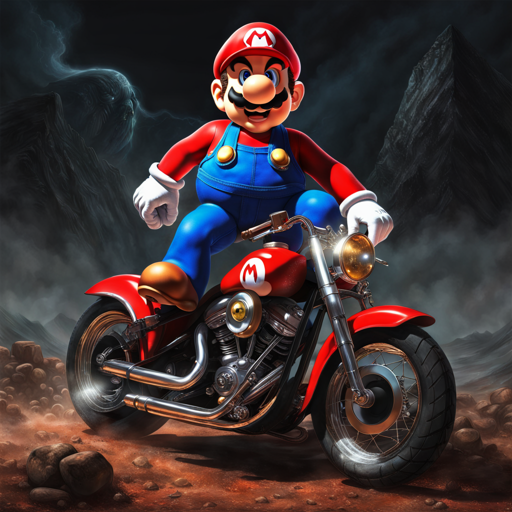

In [5]:
prompt = "hyperrealistic death metal album cover featuring edgy moody realistic (human Super Mario)++, edgy and moody" # @param {type:"string"}
cfg = 13 # @param {type:"slider", min:7, max:15, step:0.5}
seed = -1 # @param {type:"integer"}
webp_output = True # @param {type:"boolean"}

gen_image(prompt, cfg, seed, webp_output)

## MIT License

Copyright (c) 2023 Max Woolf

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.